In [1]:
# This cell imports necessary modules for anomaly detection in HEP data.
import pandas as pd
import numpy as np
import os
import gdown
from zipfile import ZipFile
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


 # Load and Preprocess the data
    - Unzip the training sample 
    - Process data in chunks
    - Select relevant features of the data
    - Normalize the data

In [4]:
# Set the file ID and the output file name
file_id = "1PVQTx8l5Pdqws9-AIMLsPm0P8jslOz2r"
file_name = "dataset/train_sample.zip"

# Construct the download URL
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
gdown.download(url, file_name, quiet=False)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1PVQTx8l5Pdqws9-AIMLsPm0P8jslOz2r 



In [5]:
# Unzip the sample data
with ZipFile('dataset/train_sample.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset/train_sample')

In [2]:
# Function to process data in chunks
def process_chunks(event_prefix, chunk_size=10000):
    hits_files = [f for f in os.listdir(event_prefix) if f.endswith('-hits.csv')]
    truth_files = [f for f in os.listdir(event_prefix) if f.endswith('-truth.csv')]

    features_list = []

    for hits_file, truth_file in zip(hits_files, truth_files):
        hits_df = pd.read_csv(os.path.join(event_prefix, hits_file), usecols=['hit_id', 'x', 'y', 'z', 'volume_id', 'layer_id', 'module_id'])
        truth_df = pd.read_csv(os.path.join(event_prefix, truth_file), usecols=['hit_id', 'particle_id', 'tpx', 'tpy', 'tpz'])
        
        merged_df = pd.merge(hits_df, truth_df, on='hit_id', suffixes=('_hit', '_truth'))

        features = merged_df[['x', 'y', 'z', 'tpx', 'tpy', 'tpz', 'volume_id', 'layer_id', 'module_id']]
        features_list.append(features)

        # Process in chunks to reduce memory usage
        if len(features_list) * chunk_size > 100000:  # Arbitrary limit to process in chunks
            features_chunk = pd.concat(features_list, ignore_index=True)
            yield features_chunk
            features_list = []

    if features_list:
        features_chunk = pd.concat(features_list, ignore_index=True)
        yield features_chunk


In [3]:
# Process the data in chunks
features_list = []
for features_chunk in process_chunks('dataset/train_sample/train_100_events'):
    features_list.append(features_chunk)

# Concatenate all chunks
data_df = pd.concat(features_list, ignore_index=True)


In [4]:
data_df.head()


,x,y,z,tpx,tpy,tpz,volume_id,layer_id,module_id
0,-87.7767,-9.850090,-1502.5,-0.354864,-0.064337,-5.35238,7,2,1
1,-61.5523,-2.110840,-1502.5,0.364564,-0.000098,-6.19294,7,2,1
2,-94.4999,-13.631400,-1502.5,-0.238809,-0.044442,-4.41116,7,2,1
3,-98.5833,-0.461182,-1502.5,-0.219582,-0.004848,-4.98515,7,2,1
4,-73.9314,-4.338970,-1502.5,-0.191599,-0.047954,-3.02802,7,2,1


In [21]:
data_df.shape

(10388131, 9)

In [5]:
# Check for and remove NaN values
data_df = data_df.dropna()
        
# Remove duplicates
data_df = data_df.drop_duplicates()


In [23]:
data_df.shape

(10388131, 9)

In [6]:
# Drop headers by resetting the index and ignoring the first row
data_df = data_df.reset_index(drop=True)
# all_features.columns = range(all_features.shape[1])


In [7]:
# Normalize the data

scaler = StandardScaler()
features_scaled = scaler.fit_transform(all_features)
features_scaled = torch.tensor(features_scaled, dtype=torch.float32)
features_scaled


NameError: name 'all_features' is not defined

In [8]:
data_df = pd.DataFrame(features_scaled)
print(data_df.describe())

NameError: name 'features_scaled' is not defined

In [10]:
# Sample 1% of the data for testing and evaluation
sample_fraction = 0.01  # Adjust this fraction as needed
data_sample = data_df.sample(frac=sample_fraction, random_state=42)


# Save the sampled data to a new CSV file
data_sample.to_csv('dataset/sample.csv', index=False)

# Display the shape of the sampled data
print(data_sample.shape)


(103881, 9)


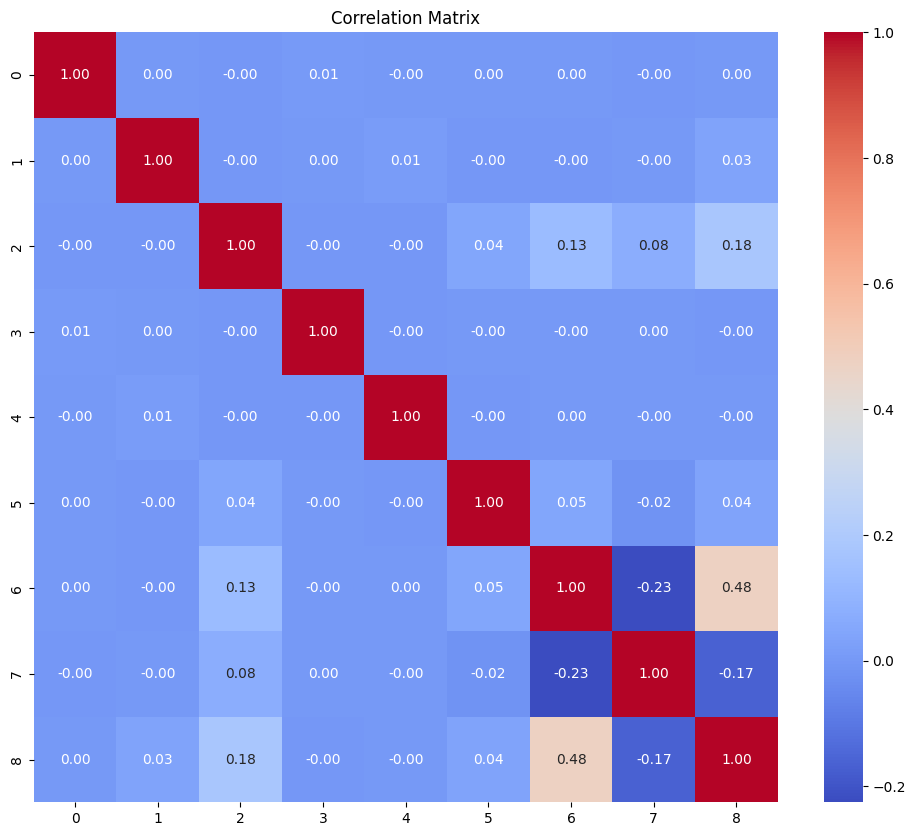

In [6]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(data_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
    


Original number of features: 9
Reduced number of features after Incremental PCA: 5


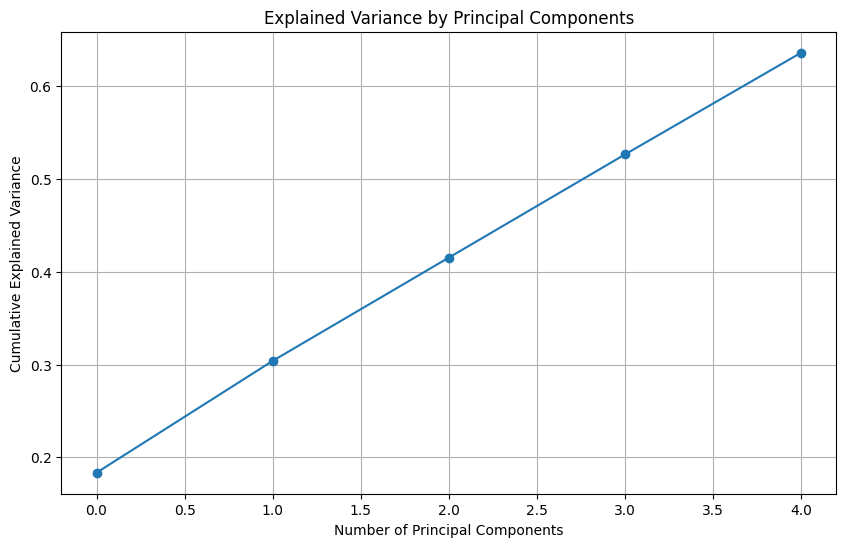

In [10]:
from sklearn.decomposition import IncrementalPCA

# Number of components must be less than the number of features
n_components = 5  # Adjust this number based on your data and requirements
batch_size = 1000  # Adjust based on memory capacity

ipca = IncrementalPCA(n_components=n_components)

for i in range(0, data_df.shape[0], batch_size):
    ipca.partial_fit(data_df[i:i + batch_size])

data_ipca = ipca.transform(data_df)

print(f"Original number of features: {data_df.shape[1]}")
print(f"Reduced number of features after Incremental PCA: {data_ipca.shape[1]}")

# Visualize the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(ipca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()


          0         1         2         3         4         5         6  \
0  0.007026  0.025138  0.283711 -0.000711  0.000970  0.108101  0.624018   
1  0.011187  0.009519  0.723696  0.000410 -0.009126  0.242148 -0.060770   
2 -0.071522  0.065104  0.017128 -0.489376  0.862856 -0.075824  0.002719   
3  0.044527  0.063520  0.005538  0.868600  0.486859 -0.046187  0.002458   
4  0.007087 -0.006717 -0.187967  0.002500  0.095688  0.959085 -0.058100   

          7         8  
0 -0.369509  0.617417  
1  0.639467  0.068681  
2  0.021249  0.011620  
3  0.015128  0.009253  
4 -0.142996 -0.108361  


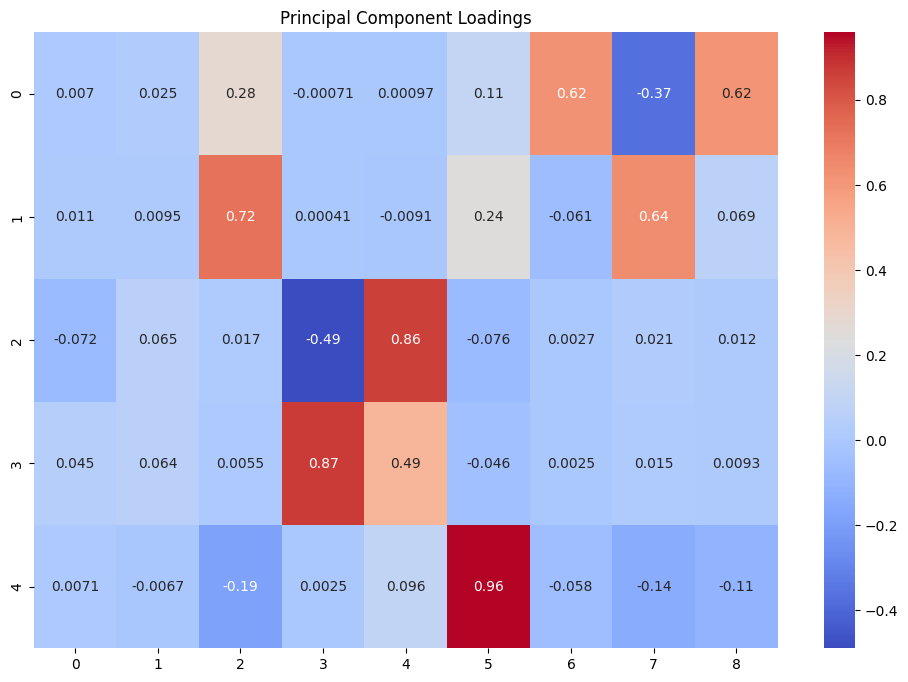

In [12]:
# Loadings of the principal components
loadings = ipca.components_

# DataFrame to visualize
loadings_df = pd.DataFrame(loadings, columns=data_df.columns)
print(loadings_df)

# Plot the loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm')
plt.title('Principal Component Loadings')
plt.show()


In [11]:
# Kinematic Features
data_sample['momentum_magnitude'] = np.sqrt(data_df['tpx']**2 + data_sample['tpy']**2 + data_sample['tpz']**2)
data_sample['transverse_momentum'] = np.sqrt(data_sample['tpx']**2 + data_sample['tpy']**2)
data_sample['phi'] = np.arctan2(data_df['tpy'], data_sample['tpx'])
theta = np.arctan2(np.sqrt(data_sample['tpx']**2 + data_sample['tpy']**2), data_sample['tpz'])
data_sample['eta'] = -np.log(np.tan(theta / 2))

# Spatial Features
data_sample['distance_from_origin'] = np.sqrt(data_sample['x']**2 + data_sample['y']**2 + data_sample['z']**2)
data_sample['transverse_distance'] = np.sqrt(data_sample['x']**2 + data_sample['y']**2)

# Detector-Related Features
data_sample['volume_layer_interaction'] = data_sample['volume_id'] * data_sample['layer_id']
data_sample['volume_layer_module_interaction'] = data_sample['volume_id'] * data_sample['layer_id'] * data_sample['module_id']

# Normalize the engineered features
engineered_features = ['momentum_magnitude', 'transverse_momentum', 'phi', 'eta',
                       'distance_from_origin', 'transverse_distance',
                       'volume_layer_interaction', 'volume_layer_module_interaction']
scaler = StandardScaler()
# data_df[engineered_features] = scaler.fit_transform(data_df[engineered_features])


In [12]:
data_scaled = scaler.fit_transform(data_sample[engineered_features])


In [13]:
data_sample.head()

,x,y,z,tpx,tpy,tpz,volume_id,layer_id,module_id,momentum_magnitude,transverse_momentum,phi,eta,distance_from_origin,transverse_distance,volume_layer_interaction,volume_layer_module_interaction
2409139,248.3420,-125.459,-1798.500,0.107348,-0.276364,6.522050,12,8,71,6.528785e+00,0.296480,-1.200304,3.784626,1819.894491,278.233193,96,6816
6127377,-236.5060,191.730,2148.500,0.389072,0.272411,0.382647,14,8,153,6.099209e-01,0.474958,0.610830,0.737070,2169.964915,304.459326,112,17136
7325346,341.6690,-119.852,-763.000,-403222.000000,231248.000000,-885402.000000,13,4,193,1.000000e+06,464826.439424,2.620886,-1.400232,844.553851,362.080388,52,10036
3324635,-49.1202,-164.385,375.497,-0.185294,-0.432626,4.101210,8,8,952,4.128126e+00,0.470637,-1.975459,2.861374,412.835584,171.566961,64,60928
9233044,456.7520,202.821,-4.200,420035.000000,-223975.000000,-879435.000000,13,6,825,1.000000e+06,476019.119206,-0.489876,-1.373268,499.776338,499.758689,78,64350


In [37]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, output_dim)
        
    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = self.dropout1(z)
        z = torch.relu(self.fc2(z))
        z = self.dropout2(z)
        x_recon = torch.sigmoid(self.fc3(z))
        return x_recon


class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

def loss_function(x, x_recon, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

In [38]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [39]:
class HEPTorchDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

# Prepare the dataset and dataloader
dataset = HEPTorchDataset(data_scaled)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)  # Adjusted batch size


In [40]:
from sklearn.model_selection import train_test_split

# Initialize the VAE
input_dim = data_scaled.shape[1]
latent_dim = 20  # Adjusted latent dimension
vae = VAE(input_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.0005)  # Adjusted learning rate

# Split data into training and validation sets
train_data, val_data = train_test_split(data_scaled, test_size=0.2, random_state=42)

# Convert to DataLoader
train_dataset = HEPTorchDataset(train_data)
val_dataset = HEPTorchDataset(val_data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [41]:
# Train the VAE
num_epochs = 50
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(batch)
        loss = loss_function(batch, x_recon, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Validation
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            x_recon, mu, logvar = vae(batch)
            loss = loss_function(batch, x_recon, mu, logvar)
            val_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss / len(val_loader.dataset):.4f}')

Epoch [1/50], Train Loss: 7.8557
Epoch [1/50], Validation Loss: 7.5483
Epoch [2/50], Train Loss: 7.5251
Epoch [2/50], Validation Loss: 7.4715
Epoch [3/50], Train Loss: 7.4781
Epoch [3/50], Validation Loss: 7.4008
Epoch [4/50], Train Loss: 7.4117
Epoch [4/50], Validation Loss: 7.3840
Epoch [5/50], Train Loss: 7.3885
Epoch [5/50], Validation Loss: 7.3373
Epoch [6/50], Train Loss: 7.3782
Epoch [6/50], Validation Loss: 7.3352
Epoch [7/50], Train Loss: 7.3711
Epoch [7/50], Validation Loss: 7.3477
Epoch [8/50], Train Loss: 7.3619
Epoch [8/50], Validation Loss: 7.3484
Epoch [9/50], Train Loss: 7.3592
Epoch [9/50], Validation Loss: 7.3220
Epoch [10/50], Train Loss: 7.3490
Epoch [10/50], Validation Loss: 7.2979
Epoch [11/50], Train Loss: 7.3256
Epoch [11/50], Validation Loss: 7.1911
Epoch [12/50], Train Loss: 7.2498
Epoch [12/50], Validation Loss: 7.1845
Epoch [13/50], Train Loss: 7.2177
Epoch [13/50], Validation Loss: 7.1196
Epoch [14/50], Train Loss: 7.1930
Epoch [14/50], Validation Loss: 7.0

In [42]:
# Detect anomalies on validation set
vae.eval()
with torch.no_grad():
    val_tensor = torch.tensor(val_data, dtype=torch.float32).to(device)
    reconstruction = vae(val_tensor)[0]
    reconstruction_error = torch.mean((reconstruction - val_tensor)**2, dim=1)

# Define k and calculate threshold
k = 3  # Experiment with different values of k (e.g., 2.5, 3, 3.5)
threshold = torch.mean(reconstruction_error) + k * torch.std(reconstruction_error)
anomalies = reconstruction_error > threshold

NameError: name 'k' is not defined

/home/hero/miniconda3/envs/pytorch_cuda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hero/miniconda3/envs/pytorch_cuda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


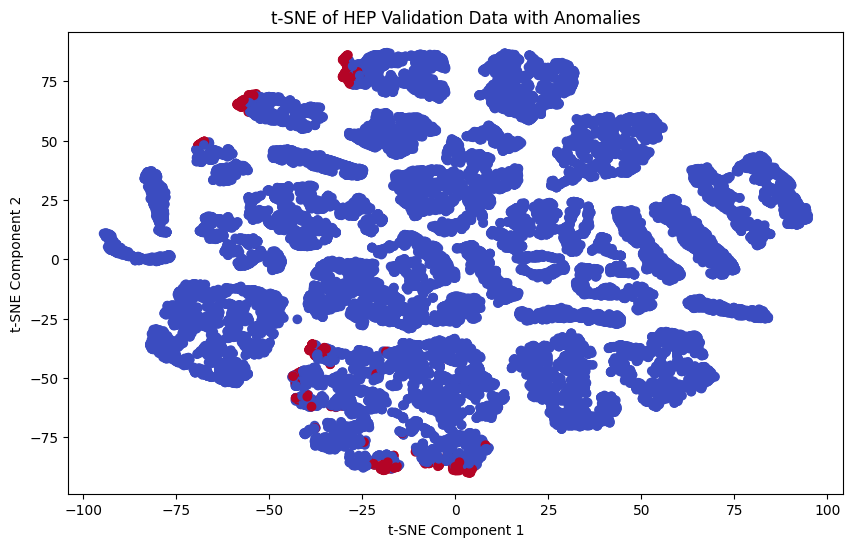

In [34]:
from sklearn.manifold import TSNE

# Visualize anomalies using t-SNE
tsne = TSNE(n_components=2)
val_tsne = tsne.fit_transform(val_data)

plt.figure(figsize=(10, 6))
plt.scatter(val_tsne[:, 0], val_tsne[:, 1], c=anomalies.cpu().numpy(), cmap='coolwarm')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of HEP Validation Data with Anomalies')
plt.show()




In [36]:
# Analyze detected anomalies
anomalous_val_data = val_data[anomalies.cpu().numpy()]
anomalous_val_data_df = pd.DataFrame(anomalous_val_data, columns=engineered_features)  # Convert to DataFrame
print(anomalous_val_data_df.describe())

       momentum_magnitude  transverse_momentum         phi         eta  \
count          432.000000           432.000000  432.000000  432.000000   
mean             1.194393             1.424179    0.033329    0.191211   
std              1.390682             1.766614    1.096097    0.657302   
min             -0.418267            -0.372384   -1.728342   -3.563464   
25%             -0.418263            -0.372383   -0.989883   -0.172635   
50%              2.390877             1.176782    0.079251    0.090226   
75%              2.390879             3.386972    1.073895    0.570298   
max              2.390880             3.642334    1.734607    2.557752   

       distance_from_origin  transverse_distance  volume_layer_interaction  \
count            432.000000           432.000000                432.000000   
mean               1.118860             1.787382                  1.270904   
std                1.211402             0.775337                  1.443094   
min               -1.